In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython import display

gym.logger.set_level(40)
np.set_printoptions(precision=2)

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display.display(display_animation(anim, default_mode='loop'))

The state has four components: position, velocity, angle, angular_velocity.
x, x_prime, theta, theta_prime

Our Q-table will be a partition into two buckets of each of these, negative and positive.
So Q-table will have dimensions (2, 2, 2, 2, 2). The last dimension reflects the value of moving left/right.

In [3]:
def reset_Q():
    return np.zeros((3, 3, 6, 3, 2))

def partition(state):
    """
    Parameters:
        state ((4,) ndarray, dtype float): position, velocity, angle, angular velocity.
    Returns:
        discrete_state (tuple(int,int,int,int)): discretized into buckets.
    """
    dstate = np.zeros(state.shape)
    # position
    if state[0] < -0.8:
        dstate[0] = 0
    elif state[0] < 0.8:
        dstate[0] = 1
    else:
        dstate[0] = 2
        
    # velocity
    if state[1] < -0.5:
        dstate[1] = 0
    elif state[1] < 0.5:
        dstate[1] = 1
    else:
        dstate[1] = 2
    
    # angle:
    if state[2] < -6:
        dstate[2] = 0
    elif state[2] < -1:
        dstate[2] = 1
    elif state[2] < 0:
        dstate[2] = 2
    elif state[2] < 1:
        dstate[2] = 3
    elif state[2] < 6:
        dstate[2] = 4
    else:
        dstate[2] = 5
        
    # angular velocity:
    if state[3] < -50:
        dstate[3] = 0
    elif -state[3] < 50:
        dstate[3] = 1
    else:
        dstate[3] = 2
                
    return tuple(dstate.astype(int))
        
def choose_move(Q_table, state, epsilon):
    """
    Epsilon-greedy strategy. epsilon percent of the time, we move randomly.
    """
    if np.random.random() < epsilon:
        return np.random.randint(Q_table.shape[-1])
    
    dstate = partition(state)
    return np.argmax(Q_table[dstate])

def update(Q_table, state, action, reward, state_prime, alpha, gamma):
    dstate, dstate_prime = partition(state), partition(state_prime)
    Q = Q_table[dstate][action]
    Q_prime = np.max(Q_table[dstate_prime])
    Q_table[dstate][action] = Q + alpha*(reward + gamma*Q_prime - Q)

In [4]:
def train_game(Q_table=None, epochs=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    env = gym.make('CartPole-v0')
    rewards = np.zeros(epochs)
    if Q_table is None:
        Q_table = reset_Q()
    for i in range(epochs):
        observation = env.reset()
        cum_reward = 0
        for i in range(500):
            action = choose_move(Q_table, state=observation, epsilon=epsilon)
            new_observation, reward, done, info = env.step(action)
            if done and i < 199:
                reward = -50
            update(Q_table=Q_table, state=observation, action=action, reward=reward, state_prime=new_observation, alpha=alpha, gamma=gamma)
            observation = new_observation
            cum_reward += reward
            if done:
                break
        rewards[i] = cum_reward

    env.close()
    return rewards, Q_table
    

def play_game(Q_table, epsilon=0):
    env = gym.make('CartPole-v0')
    observation = env.reset()
    rewards = []
    frames = []
    for i in range(500):
        frames.append(env.render(mode='rgb_array'))
        action = choose_move(Q_table, observation, epsilon=epsilon)
        new_observation, reward, done, info = env.step(action)
        observation = new_observation
        rewards.append(reward)
        if done:
            break
    env.close()

    return np.sum(rewards), frames

def demonstrate_game(Q_table, epsilon=0):
    reward, frames = play_game(Q_table, epsilon)
    print("Reward",reward)
    display_frames_as_gif(frames)

In [5]:
def plot_rewards(rewards):
    """
    Plot the histogram, rolling average
    """
    assert isinstance(rewards, (np.ndarray, np.generic) )    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    print("Average Score:", np.mean(rewards))
    axs[0].hist(rewards)
    axs[0].set_title("Histogram of Scores")
    
    N = len(rewards)
    num_buckets = 40
    items_per_bucket = N//num_buckets
    xs = np.arange(0,num_buckets)*items_per_bucket
    reward_buckets = [ np.mean(rewards[x:x+items_per_bucket]) for x in xs ]
    axs[1].plot(xs, reward_buckets)
    axs[1].set_title("Rolling Average Score per Iteration")
    plt.show()

def display_Q(Q_table):
    """
    Plot the Q_table in understandable form.
    """
    Q_min = np.min(Q_table)
    Q_max = np.max(Q_table)
    print("Min: {}, Max: {}".format(Q_min, Q_max))
    print(Q_table)

Average Score: 11.396


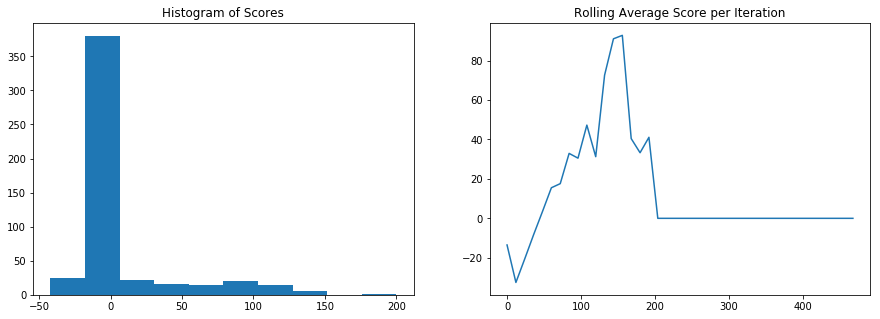

NoSuchDisplayException: Cannot connect to "None"

In [6]:
rewards, Q_table = train_game(epochs=500, epsilon=0.1)
plot_rewards(rewards)
demonstrate_game(Q_table, epsilon=0.1)

In [ ]:
demonstrate_game(Q_table, epsilon=0)

In [ ]:
rewards, _ = train_game(epochs=200, epsilon=0.5)
plot_rewards(rewards)

In [ ]:
Q_table = reset_Q()
r1, _= train_game(Q_table, epochs=200, epsilon=0.2)
r2, _ = train_game(Q_table, epochs=200, epsilon=0.1)
r3, _ = train_game(Q_table, epochs=200, epsilon=0.05)
r4, _ = train_game(Q_table, epochs=400, epsilon=0)
rewards = np.concatenate((r1, r2, r3, r4))

plot_rewards(rewards)

In [ ]:
demonstrate_game(Q_table)

In [ ]:
def display_Q(Q_table):
    """
    Plot the Q_table in understandable form.
    """
    Q_min = np.min(Q_table)
    Q_max = np.max(Q_table)
    print("Min: {}, Max: {}".format(Q_min, Q_max))
    print(Q_table)
    
display_Q(Q_table)